# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [RAMP](https://www.ramp.studio/problems/HEP_tracking) on charged particle tracking in 2D with a possible future LHC Silicon detector

_Thomas Boser (CHALEARN), Isabelle Guyon (LRI UPSud/INRIA), Mikhail Hushchyn (YSDA/Russia), Balázs Kégl (LAL/Orsay), David Rousseau (LAL/Orsay), Yetkin Yılmaz (LAL/Orsay)_

## Introduction

Tracking is one of the most important tasks in a high-energy physics experiment, as it provides high-precision position and momentum information belonging to charged particles. Such information is crucial for a diverse variety of physics studies - from Standard Model tests to new particle searches - which requires robust low-level optimization without information loss which can be further refined for a narrower and more specific physics context.

Through the history of high-energy physics, there have been many different types of tracking detectors with very different design principles: from bubble chambers to time-projection chambers, from proportional counters to spark chambers... Although each of these have provided a different data topology, they all relied on simple basics: the small energy deposit of particles in well-defined locations, with particles bending in an externally applied magnetic field.

In this challenge, we focus on the topology of silicon detectors in which there are few locations along the polar axis, however a very high precision along the azimuth. Such topology helps to reduce the tracking problem to layer-by-layer azimuth determination, however, we hope to open room for further innovation as well.


## Quick Glossary

We use the following vocabulary in the context of this challenge. It may be slightly different from the general high-energy physics context. Some terms are not used in the workbook, but kept here in case they are used in the discussions.

* **event**: a recorded (or simulated) collision in which many particles are present, the basic unit of particle physics data
* **pixel**: the smallest detector unit
* **hit**: a pixel through which a particle has passed and left signal in a given event
* **cluster**: a set of hits, belonging (or predicted to be belonging) to the trajectory of a single particle
* **reconstruct**: same thing as predict, but may also refer to further derived quantities
* **track**: a reconstructed particle, that is, a cluster but also including additional derived information, such as the overall curvature and angle
* **vertex**: the point close to the center of the detector, from which the particles have originated
* **impact parameter**: the shortest distance between a track and the origin
* **(momentum/angle/etc) resolution** : width of the normal distribution of the difference between a predicted quantity and the true value of that quantity

## Objectives

The main objective of the challenge is the optimal matching of the hits in an event. The positions of the hits in the detector are provided as input data, and the user is expected to implement a clustering scheme (trained on data if needed), so that every hit is assigned to a cluster id.

The value of the cluster id itself is not relevant for the task, what is relevant is which hits are clustered together, and whether this clustering corresponds well to the input particles. The score function that describes this is included in the notebook, and details will be mentioned there.

## Application

The user is expected to implement the class `clusterer.py`, which contains the `__init__`, `fit`, and `predict_single_event` functions.

* **`__init__`** is where parameters should be set.
* **`fit`** is the training function (not to be confused with track-fitting), where the algorithm has access to the ground-truth. This function is to be run once on an input array that contains a set of training events. The user is able to implement any event-level or particle-level segmentation of the input array in order to set up the training in any desired way.
* **`predict_single_event`** is the function to reconstruct the hit clusters (tracks), returning an array of predicted (reconstructed) ids associated to each hit in the input array. This function takes only the hits from a single event as input, with the event_id dropped, and the RAMP machinery takes care of running this function on each event.

The **task** in the challenge is to implement this class in a way that the predict_single_event function returns a numpy array of assigned cluster ids. At any level of this task, machine-learning techniques can be employed for sub-tasks defined by the user.

## Detector

Image from the Atlas experiment:

![Atlas detector](http://atlasexperiment.org/photos/atlas_photos/selected-photos/events/atlas2009-collision-atlantis-141749-405315-hits-web.png)

The data provided to the user is a list of hit positions from a simple toy detector model that mimics the Atlas detector design (which is generic enough for recent silicon-based tracking detectors). The detector has an onion-like geometry with 9 layers surrounding the origin with polar distances of $R = [39,85,155,213,271,405,562,762,1000]$ cm. These layers have a very small thicknesses compared to the distances, therefore the thickness can be neglected.

Each layer is segmented in azimuth with high granularity. There are ($2\pi$R/pitch)+1 pixels in every layer, where pitch is 0.025 cm for layers 0-4 and 0.05 cm for layers 5-9.

Every "pixel" corresponds to the smallest detector unit defined by `layer` and `iphi` (azimuthal index).

## Simulation

The challenge uses a toy model for particle generation and simulation, in which a Poisson distribution is sampled to determine the number of particles in each event, with an average of 10 particles per event.

The particles are sampled uniformly in azimuth and momentum with bounds on the momentum. Each particle originates from a vertex that is also randomly sampled from a narrow normal distribution around the origin. The proper dimensions of the momentum and position and determination of these values for the tracks are beyond the scope of the challenge.

The particles generated this way are simulated in a uniform magnetic field. The detector material is considered to cause multiple-scattering, and this is implemented as a random rotation of the particle momentum at every detector position, sampled from a narrow normal distribution that roughly corresponds to the material of the Atlas tracker.

In addition, some hit inefficiency is simulated by a random drop of some hits (with 3% probability), and a particle stopping probability of 1% is applied at each layer to simulate effects of hadronic interactions. Keeping these in mind, the algorithms might be desired to be able to handle cases when the particle doesn't have a hit on every layer.

Since the detector has a very high granularity in azimuth, the cases where two particles pass through a single pixel are neglected (less than 0.2% probability).

## Beyond the challenge

The following aspects of tracking fall out of scope of the challenge:

* Track fitting
* Particle efficiency
* Fake tracks
* Momentum resolution
* Vertex finding and impact parameter resolution
* Tracking in 3D

Fake combinatorial tracks do affect the score in an indirect way, by reducing the efficiency due to one-to-one assignment between true and predicted cluster ids. If there are fake tracks, that is, clusters that contain hits belonging to many different particles, then the good cluster attached to each of these particles will be missing some of the hits.

## Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
filename = "data/train.csv"
df = pd.read_csv(filename)

The data consists of the following columns:

* **`event_id`** (integer): The event number; particles that have the same event id belong to the same event. Notice that the event ids are not consecutive since this is a randomly sampled subset of the full sample.
* **`cluster_id`** (integer): The true cluster id corresponds to the particle that created the hits. The predicted cluster id will correspond to the label of the cluster that is reconstructed. The value itself of the reconstructed cluster is irrelevant, what matters is how the hits are grouped with those ids. The only requirement on the predicted cluster ids is that they are non-negative for properly reconstructed clusters. A value of -1 means that hit is not associated to any cluster.
* **`layer`** (integer): The detector layer that the hit sits in, representing how far the hit is from the origin. The distances of the various layers were mentioned above in *Detector*.
* **`iphi`** (integer): The azimuthal id of the pixel along a given layer. The $\phi$ position of the hit can be determined form this value based on how many segmentations that layer has, which was described in *Detector*.
* **`x`** (float): The $x$ position of the hit, in cm.
* **`y`** (float): The $y$ position of the hit, in cm.

Notice that the information provided in data is redundant: the `layer` & `iphi` and `x` & `y` values can be computed from each other. It is provided this way for the sake of convenience, so be careful when you need to feed algorithms with independent variables.

The array indices of the above variables may change depending on whether the event id has been dropped or not, therefore make sure you are careful in using the index for the variable you want to pick up.

In [3]:
df

,event_id,cluster_id,layer,iphi,x,y
0,4,8,2,7830,46.974183,147.710616
1,4,4,5,42052,186.731559,-359.383256
2,4,9,3,46355,141.775135,-158.961666
3,4,10,1,18866,63.089465,-56.962438
4,4,0,3,22217,-183.348295,108.408499
5,4,3,6,6880,459.967978,322.914012
6,4,6,8,22862,414.778170,909.922562
7,4,8,6,14056,176.935865,533.420753
8,4,5,8,9204,895.964168,444.126344
9,4,5,1,1501,76.850693,36.317639


In [4]:
y = df[['event_id', 'cluster_id']].values
X = df.drop(['cluster_id'], axis=1).values

### Looping over events

In [5]:
y_events = y[:, 0]

In [6]:
events = np.unique(y_events)

### Visualize the hits in a single event

In [56]:
event_id = 42
event_indices = (X[:, 0] == event_id)
X_event = X[event_indices, 1:] # event_id column dropped
pixel_x = X_event[:, 2]
pixel_y = X_event[:, 3]
tracks = y[event_indices][: ,1]

#### Hits from all tracks

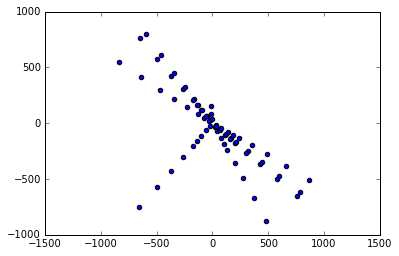

In [57]:
plt.scatter(pixel_x, pixel_y)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single track

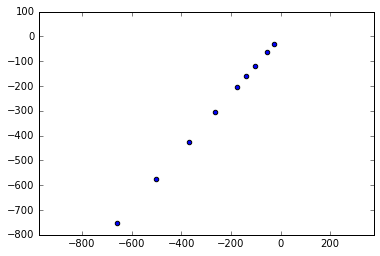

In [58]:
track_id = 2
track_hits = (tracks == track_id)
plt.scatter(pixel_x[track_hits], pixel_y[track_hits])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

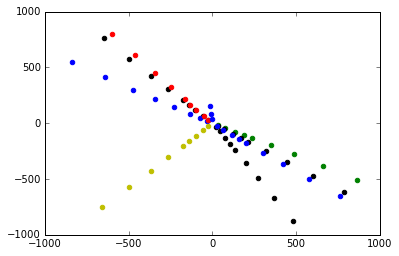

In [59]:
cmap = ['k', 'b', 'y', 'g', 'r', 'k', 'b']
for track_id in np.unique(tracks):
    track_hits = (tracks == track_id)
    plt.scatter(pixel_x[track_hits], pixel_y[track_hits], color=cmap[int(track_id) % 7])
plt.show()

## The clustering workflow

The pipeline consists of a single element `clusterer.py` which should contain a class `Clusterer` implementing an `fit` function and a `predict_single_event` function. This letter should output a 1D integer array, grouping hits with the same id together.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [40]:
%%file submissions/starting_kit/clusterer.py
import numpy as np
from sklearn.base import BaseEstimator


class Clusterer(BaseEstimator):
    def __init__(self):
        """
        Track pattern recognition.

        Based on the connections between two nearest hits from two nearest
        detector layers.

        Parameters
        ----------
        min_cos_value : float
            Minimum cos value between two nearest segments of the track.
        """
        self.min_cos_value = 0.8

    def fit(self, X, y):
        pass

    def predict_single_event(self, X_event):
        layers, x, y = X_event[:, 0], X_event[:, 2], X_event[:, 3]
        used = np.zeros(len(x))
        labels = -1 * np.ones(len(x), dtype='int')
        track_id = 0

        # Start from a hit in the first layer
        for first_id in np.arange(0, len(x))[layers == 0]:
            track = []
            track += [first_id]
            used[first_id] = 1

            # Go through other detector layers
            for one_layer in np.unique(layers)[1:]:
                # Select hits of the layer
                hit_ids = np.arange(0, len(x))[
                    (layers == one_layer) * (used == 0)]
                # Compute distance between hits
                diff_r = (x[track[-1]] - x[hit_ids]) ** 2\
                    + (y[track[-1]] - y[hit_ids]) ** 2
                if len(diff_r) == 0:
                    break
                # Select new track hit
                track_hit_id = hit_ids[diff_r == diff_r.min()][0]
                # Check cos of angle between two track segments
                if one_layer != 1:
                    x1, x2, x3 = x[track[-2]], x[track[-1]], x[track_hit_id]
                    y1, y2, y3 = y[track[-2]], y[track[-1]], y[track_hit_id]
                    dx1, dx2 = x2 - x1, x3 - x2
                    dy1, dy2 = y2 - y1, y3 - y2
                    cosine = (dx1 * dx2 + dy1 * dy2) /\
                        np.sqrt((dx1 ** 2 + dy1 ** 2) * (dx2 ** 2 + dy2 ** 2))
                    if cosine < self.min_cos_value:
                        break
                # Add new hit to the track
                track += [track_hit_id]
                used[track_hit_id] = 1
            # Label the track hits
            labels[track] = track_id
            track_id += 1
        return labels



Overwriting submissions/starting_kit/clusterer.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission file before submitting it</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python file `clusterer.py` is in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [14]:
!ramp_test_submission

Testing Particle tracking in the LHC ATLAS detector
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	train clustering efficiency = 0.841
	valid clustering efficiency = 0.848
	test clustering efficiency = 0.849
----------------------------
train clustering efficiency = 0.841 ± 0.0
valid clustering efficiency = 0.848 ± 0.0
test clustering efficiency = 0.849 ± 0.0
----------------------------
Testing if the notebook can be converted to html
[NbConvertApp] Converting notebook ./HEP_tracking_starting_kit.ipynb to html
[NbConvertApp] Writing 396685 bytes to ./HEP_tracking_starting_kit.html


Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [15]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [16]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [HEP tracking](https://www.ramp.studio/events/HEP_tracking) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/HEP_tracking/sandbox) and copy-paste (or upload) [`clusterer.py`](http://localhost:8890/edit/submissions/starting_kit/clusterer.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/HEP_tracking/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/HEP_tracking/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/HEP_tracking/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train clustering efficiency = 0.841 ± 0.0
valid clustering efficiency = 0.848 ± 0.0
test clustering efficiency = 0.849 ± 0.0
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/HEP_tracking/leaderboard)) is clustering efficency, so the line that is relevant in the output of `ramp_test_submission` is `valid clustering efficiency = 0.848 ± 0.0`. When the score is good enough, you can submit it at the RAMP.

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [17]:
import imp
problem = imp.load_source('', 'problem.py')

Get the training data.

In [18]:
X_train, y_train = problem.get_train_data()

In [19]:
X_train

array([[  4.00000000e+00,   2.00000000e+00,   7.83000000e+03,
          4.69741834e+01,   1.47710616e+02],
       [  4.00000000e+00,   5.00000000e+00,   4.20520000e+04,
          1.86731559e+02,  -3.59383256e+02],
       [  4.00000000e+00,   3.00000000e+00,   4.63550000e+04,
          1.41775135e+02,  -1.58961666e+02],
       ..., 
       [  1.99890000e+04,   4.00000000e+00,   5.57980000e+04,
          1.14204060e+02,  -2.45760926e+02],
       [  1.99890000e+04,   1.00000000e+00,   4.54800000e+03,
          1.96395116e+01,   8.26999975e+01],
       [  1.99890000e+04,   0.00000000e+00,   4.86200000e+03,
         -3.89878137e+01,   9.74875478e-01]])

In [20]:
y_train

array([[    4,     8],
       [    4,     4],
       [    4,     9],
       ..., 
       [19989,     2],
       [19989,     0],
       [19989,     3]])

Get the first cv fold, creating training and validation indices. The [particular CV](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/cvs/clustering.py) creates folds that don't cut through events. We use a single train/test cut.

In [21]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]

In [32]:
test_is

array([[   42,     3],
       [   42,     2],
       [   42,     3],
       ..., 
       [19978,     2],
       [19978,     2],
       [19978,     3]])

Train your starting kit.

In [23]:
cls = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [24]:
y_pred = problem.workflow.test_submission(cls, X_train)

Print the training and validation scores.

In [26]:
score_train = problem.score_types[0](y_train[train_is], y_pred[train_is])
print(score_train)

0.840562926519


In [27]:
score_test = problem.score_types[0](y_train[test_is], y_pred[test_is])
print(score_test)

0.847878182689


Get the independent test data.

In [28]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [30]:
y_test_pred = problem.workflow.test_submission(cls, X_test)

Print the test score.

In [31]:
score_test = problem.score_types[0](y_test, y_test_pred)
print(score_test)

0.849076880151


To see what how the workflow, the cross-validation, and the score work, visit [rw.workflows.clusterer](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/clusterer.py), [rw.cvs.clustering](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/cvs/clustering.py), and [rw.score_types.clustering_efficiency](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/score_types/clustering_efficiency.py).

### Visualizing the prediced tracks for the same event we looked at above.

In [69]:
y_pred_event = y_pred[y_pred[:, 0] == event_id]

In [70]:
tracks = y_pred_event[:, 1]
tracks

array([ 6,  3,  6,  3,  1,  1,  8,  8,  3,  0,  4, -1,  7,  0,  1,  2,  0,
        4,  8,  3,  7,  4,  2,  2,  1,  1,  1,  3,  2,  4,  2,  2,  0,  6,
        8,  3,  3,  4,  0,  8,  0,  6, -1,  1,  8,  6,  6,  6,  2,  4,  0,
        1, -1,  6, -1,  5,  8,  2,  1,  5,  4,  6,  7,  0, -1,  8,  3,  3,
        4,  2,  4,  8,  0,  5])

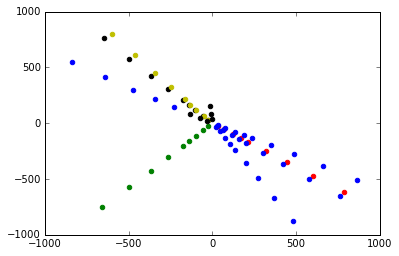

In [71]:
for track_id in np.unique(tracks):
    track_hits = (tracks == track_id)
    plt.scatter(pixel_x[track_hits], pixel_y[track_hits], color=cmap[int(track_id) % 7])
plt.show()

It seems the algorithm missed a complete track.

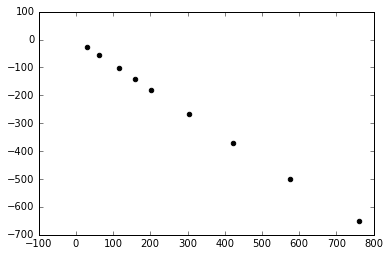

In [72]:
unassigned_hits = (tracks == -1)
plt.scatter(pixel_x[track_hits], pixel_y[track_hits], color='black')
plt.show()

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=HEP tracking notebook).